# Лабораторная 3. Разметка и аугментация данных

## ФИО: Фам Данг Чунг Нгиа
## Группа учебы: P3321
## ISU: 374806

## Загрузить файл и распакировать его

In [1]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]
print("Uploaded file:", zip_filename)

extract_dir = "racoon_data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Распакуйте его. Файлы внутри папки", extract_dir, ":")
!ls racoon_data

Saving archive.zip to archive.zip
Uploaded file: archive.zip
Распакуйте его. Файлы внутри папки racoon_data :
'Racoon Images'   train_labels_.csv


## Разметание датасета

### Чтение датасета

In [2]:
import os
import pandas as pd

csv_path = "racoon_data/train_labels_.csv"

df = pd.read_csv(csv_path)

print("Номер строки в файле label:", len(df))
print("\nСтолбцы в файле:")
print(df.columns)

print("\n5 первых строк:")
print(df.head())


Номер строки в файле label: 173

Столбцы в файле:
Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

5 первых строк:
         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


### Отображение фотографий + рисование bounding box из CSV

Показывать фотографии: racoon_data/Racoon Images/images/raccoon-17.jpg


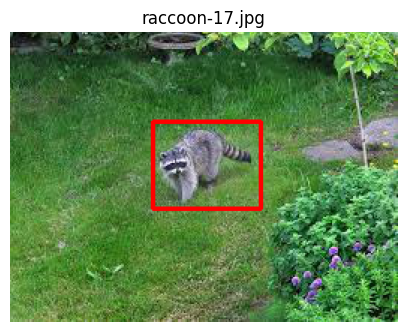

Показывать фотографии: racoon_data/Racoon Images/images/raccoon-63.jpg


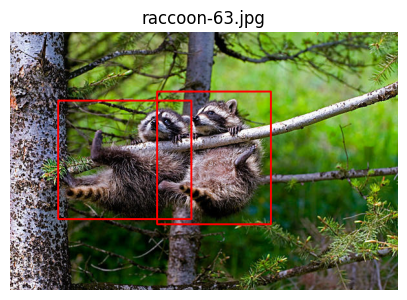

Показывать фотографии: racoon_data/Racoon Images/images/raccoon-60.jpg


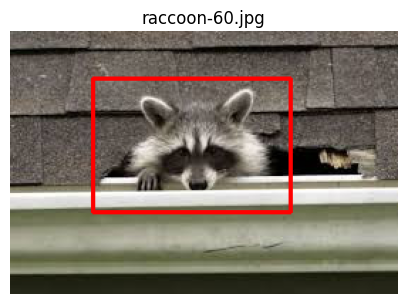

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

import pandas as pd

csv_path = "racoon_data/train_labels_.csv"
df = pd.read_csv(csv_path)

images_dir = "racoon_data/Racoon Images/images"

def show_image_with_bboxes(row_index):
    filename = df.iloc[row_index]["filename"]
    img_path = os.path.join(images_dir, filename)

    print("Показывать фотографии:", img_path)

    img = cv2.imread(img_path)
    if img is None:
        print("Не удается прочитать фотографию, проверьте путь еще раз!")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Отфильтруйте все bounding boxes, относящиеся к этой фотографии
    boxes = df[df["filename"] == filename]

    # Нарисуйте каждый bounding box
    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        cv2.rectangle(
            img_rgb,
            (xmin, ymin),
            (xmax, ymax),
            (255, 0, 0),
            2
        )

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(filename)
    plt.axis("off")
    plt.show()

show_image_with_bboxes(0)
show_image_with_bboxes(2)
show_image_with_bboxes(4)

## (Подготовка к аргментации) Сбор заметки по каждой фотографии

Собрать заметки по каждой фотографии

In [15]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

csv_path = "racoon_data/train_labels_.csv"
df = pd.read_csv(csv_path)

images_dir = "racoon_data/Racoon Images/images"

# id для класса (только "raccoon")
class_to_id = {"raccoon": 0}

samples = []

# собирать все рамки по названию фотографии
for filename, group in df.groupby("filename"):
    boxes = []
    labels = []

    for _, row in group.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        boxes.append([xmin, ymin, xmax, ymax])

        cls_name = row["class"]
        labels.append(class_to_id[cls_name])

    samples.append({
        "filename": filename,
        "filepath": os.path.join(images_dir, filename),
        "boxes": boxes,
        "labels": labels,
    })

print("Количество разных фото:", len(samples))

Количество разных фото: 160


Найти примеры, которые имеют более 2 рамки

In [17]:
# найти примеры, которые имеют более 2 рамки
multi_box_indices = []

for i, sample in enumerate(samples):
    if len(sample["boxes"]) > 1:
        multi_box_indices.append(i)

print("\nКоличество доступных фотографий >=2 енота:", len(multi_box_indices))
print("Первые несколько индексов:", multi_box_indices[:10])



Количество доступных фотографий >=2 енота: 12
Первые несколько индексов: [17, 19, 20, 27, 39, 66, 83, 91, 96, 119]


Посмотреть примеры после сбора заметки

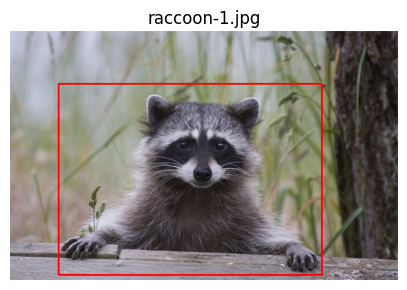

Sample index: 0
filename: raccoon-1.jpg
filepath: racoon_data/Racoon Images/images/raccoon-1.jpg
boxes: [[81, 88, 522, 408]]
labels: [0]
------------------------------------------------------------


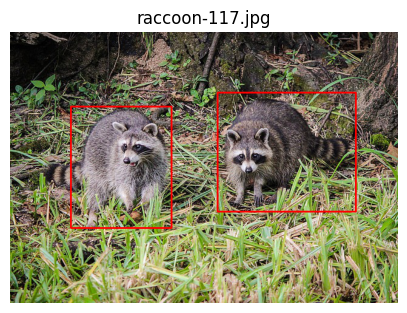

Sample index: 17
filename: raccoon-117.jpg
filepath: racoon_data/Racoon Images/images/raccoon-117.jpg
boxes: [[100, 124, 266, 324], [342, 101, 570, 297]]
labels: [0, 0]
------------------------------------------------------------


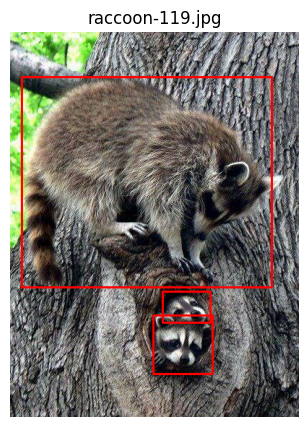

Sample index: 19
filename: raccoon-119.jpg
filepath: racoon_data/Racoon Images/images/raccoon-119.jpg
boxes: [[16, 62, 362, 353], [211, 359, 277, 402], [198, 392, 280, 473]]
labels: [0, 0, 0]
------------------------------------------------------------


In [20]:
def show_sample(idx):
    sample = samples[idx]

    # чтение фото
    img = cv2.imread(sample["filepath"])
    if img is None:
        print("Не удается прочитать фотографию, проверьте путь еще раз!")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # рисовать рамки
    for (xmin, ymin, xmax, ymax) in sample["boxes"]:
        cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # показать фото
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(sample["filename"])
    plt.axis("off")
    plt.show()

    # печатать информации
    print(f"Sample index: {idx}")
    print("filename:", sample["filename"])
    print("filepath:", sample["filepath"])
    print("boxes:", sample["boxes"])
    print("labels:", sample["labels"])
    print("-" * 60)

# примеры
show_sample(0)
show_sample(17)
show_sample(19)

## Аргментация для детекции объектов

### Скачать библиотеки

In [21]:
!pip install -q albumentations==1.4.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 4.7 MB/s eta 0:00:00


### Создать канал аргментации для детекции объектов

In [24]:
import albumentations as A

transform = A.ReplayCompose(
    [
        A.HorizontalFlip(p=0.5), # Переверните фотографию по горизонтали влево-вправо
        A.RandomBrightnessContrast(p=0.5), # Произвольно увеличивайте / уменьшайте яркость и контрастность изображений.
        A.ShiftScaleRotate(
            shift_limit=0.1, # перевести фотографию вверх / Вниз / Влево / Вправо
            scale_limit=0.1,  # увеличение / уменьшение масштаба фотографий
            rotate_limit=15,  # поворачивать фотографии
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=0.7,
        ),
        A.GaussianBlur(p=0.3), # Размыть фотографию
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",       # [xmin, ymin, xmax, ymax]
        label_fields=["class_labels"],
        min_visibility=0.3, # удалите слишком мелкие срезанные коробочки
    ),
)

### Попробовать применить аугментацию на несколько фото и посмотреть их результаты

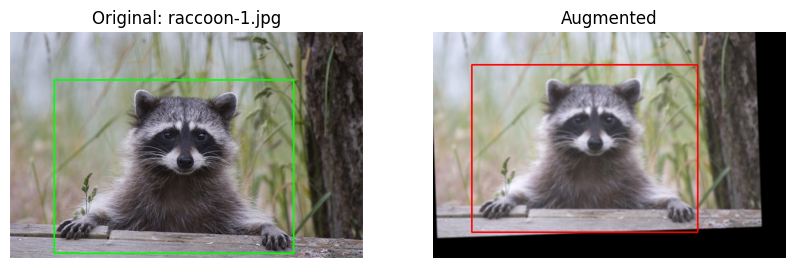

Applied transforms: RandomBrightnessContrast, ShiftScaleRotate, GaussianBlur
------------------------------------------------------------


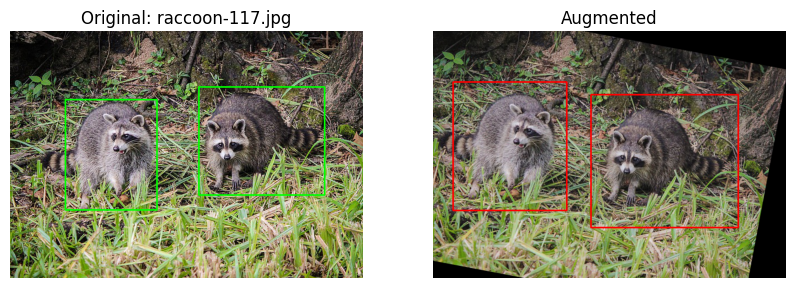

Applied transforms: RandomBrightnessContrast, ShiftScaleRotate
------------------------------------------------------------


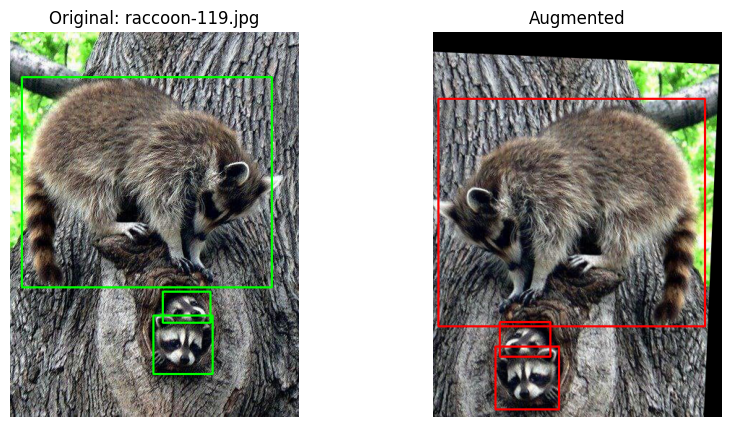

Applied transforms: HorizontalFlip, ShiftScaleRotate
------------------------------------------------------------


In [29]:
import random

def show_augmented_sample(sample_idx=None):
    # If no index provided, choose random sample
    if sample_idx is None:
        sample_idx = random.randint(0, len(samples) - 1)

    sample = samples[sample_idx]

    # Read image
    img = cv2.imread(sample["filepath"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bboxes = sample["boxes"]
    labels = sample["labels"]
    class_labels = labels  # here just numeric labels, OK for Albumentations

    # Apply augmentation
    augmented = transform(
        image=img,
        bboxes=bboxes,
        class_labels=class_labels,
    )

    aug_img = augmented["image"]
    aug_bboxes = augmented["bboxes"]
    aug_labels = augmented["class_labels"]

    # Draw boxes on original image
    img_orig = img.copy()
    for (xmin, ymin, xmax, ymax) in bboxes:
        cv2.rectangle(img_orig, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  # green

    # Draw boxes on augmented image
    img_aug_vis = aug_img.copy()
    for (xmin, ymin, xmax, ymax) in aug_bboxes:
        cv2.rectangle(img_aug_vis, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)  # red

    # Show both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_orig)
    plt.title(f"Original: {sample['filename']}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_aug_vis)
    plt.title("Augmented")
    plt.axis("off")

    plt.show()

    replay = augmented["replay"]
    applied_transforms = []
    for t in replay["transforms"]:
        if t["applied"]:
            full_name = t["__class_fullname__"]
            name = full_name.split(".")[-1]
            applied_transforms.append(name)

    if applied_transforms:
        print("Applied transforms:", ", ".join(applied_transforms))
    else:
        print("Applied transforms: None")
    print("-" * 60)

# Test with some sample
show_augmented_sample(0)
show_augmented_sample(17)
show_augmented_sample(19)

## Применение на все датасет и сохранения нового датасета

Создать директорию и файл csv для сохранения нового

In [30]:
import os
import csv

# New folder contains augmented images
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f"{output_dir}/images", exist_ok=True)

# New file CSV saves augmented images' bounding boxes
output_csv = f"{output_dir}/labels.csv"

In [31]:
num_aug_per_image = 3   # каждое исходное фото имеет 3 аргментации

rows = []

for sample in samples:
    filename = sample["filename"]
    filepath = sample["filepath"]
    boxes = sample["boxes"]
    labels = sample["labels"]

    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for i in range(num_aug_per_image):
        # augment
        augmented = transform(
            image=img,
            bboxes=boxes,
            class_labels=labels
        )

        aug_img = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_labels = augmented["class_labels"]

        new_filename = filename.replace(".jpg", f"_aug{i}.jpg")
        out_path = f"{output_dir}/images/{new_filename}"

        # сохранить фото (RGB → BGR)
        cv2.imwrite(out_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        # сохранить заметки каждой рамки
        for bbox, lbl in zip(aug_bboxes, aug_labels):
            xmin, ymin, xmax, ymax = map(int, bbox)
            rows.append([new_filename, aug_img.shape[1], aug_img.shape[0], "raccoon",
                         xmin, ymin, xmax, ymax])

# записать file CSV
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"])
    writer.writerows(rows)

print("Количество созданных дополнительных изображений:", len(rows))
print("Сохраненные заметки:", output_csv)


Количество созданных дополнительных изображений: 519
Сохраненные заметки: augmented_data/labels.csv


## Проверка нового датасета

Проверить новый файл csv для сохранения заметки рамки

In [32]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

aug_csv_path = "augmented_data/labels.csv"
df_aug = pd.read_csv(aug_csv_path)

aug_images_dir = "augmented_data/images"

print("Количество строк в .csv:", len(df_aug))
print("5 первые строки:")
print(df_aug.head())

Количество строк в .csv: 519
5 первые строки:
              filename  width  height    class  xmin  ymin  xmax  ymax
0   raccoon-1_aug0.jpg    650     417  raccoon    16    47   540   417
1   raccoon-1_aug1.jpg    650     417  raccoon   128    88   569   408
2   raccoon-1_aug2.jpg    650     417  raccoon    17    41   484   417
3  raccoon-10_aug0.jpg    450     495  raccoon   130     2   446   488
4  raccoon-10_aug1.jpg    450     495  raccoon     3     2   320   488


Проверить аугментированные фотографии

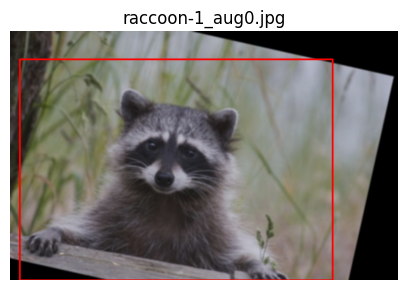

Image path:  augmented_data/images/raccoon-1_aug0.jpg
------------------------------------------------------------


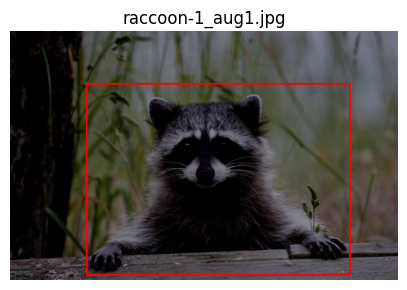

Image path:  augmented_data/images/raccoon-1_aug1.jpg
------------------------------------------------------------


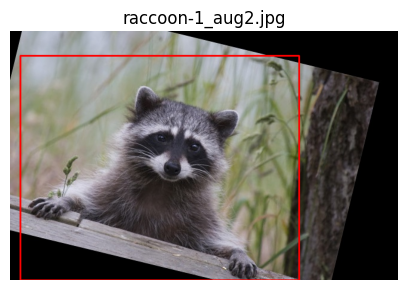

Image path:  augmented_data/images/raccoon-1_aug2.jpg
------------------------------------------------------------


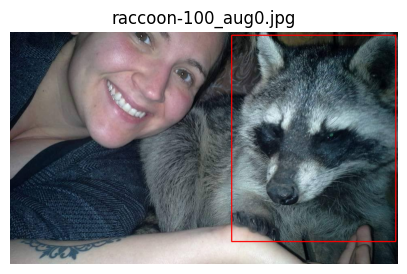

Image path:  augmented_data/images/raccoon-100_aug0.jpg
------------------------------------------------------------


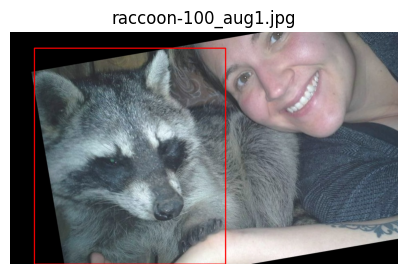

Image path:  augmented_data/images/raccoon-100_aug1.jpg
------------------------------------------------------------


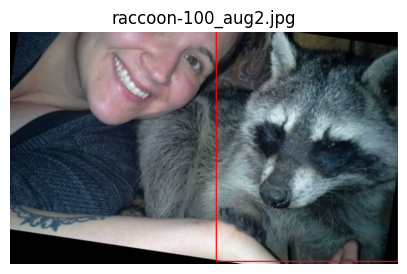

Image path:  augmented_data/images/raccoon-100_aug2.jpg
------------------------------------------------------------


In [38]:
def show_aug_image_with_bboxes(row_index):
    filename = df_aug.iloc[row_index]["filename"]
    img_path = os.path.join(aug_images_dir, filename)

    img = cv2.imread(img_path)
    if img is None:
        print("Не могу прочитать картинку, проверьте путь!")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes = df_aug[df_aug["filename"] == filename]

    for _, row in boxes.iterrows():
        xmin, ymin = int(row["xmin"]), int(row["ymin"])
        xmax, ymax = int(row["xmax"]), int(row["ymax"])
        cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(filename)
    plt.axis("off")
    plt.show()
    print("Image path: ", img_path)
    print("-" * 60)

show_aug_image_with_bboxes(0)
show_aug_image_with_bboxes(1)
show_aug_image_with_bboxes(2)

show_aug_image_with_bboxes(6)
show_aug_image_with_bboxes(7)
show_aug_image_with_bboxes(8)

## Вывод

В ходе лабораторной работы был выполнен полный цикл подготовки данных для задачи детекции объектов. Были изучены и проверены исходные разметки датасета Raccoon Detection, сформирована структура данных, удобная для дальнейшей обработки, а также реализована аугментация изображений с корректным преобразованием ограничивающих рамок. На основе разработанного пайплайна был создан расширенный набор данных, что повышает устойчивость и обобщающую способность будущих моделей детекции. Полученный результат полностью готов для последующего этапа — обучения нейросетевых моделей обнаружения объектов.